<a href="https://colab.research.google.com/github/babaroscopy/Thesis/blob/main/Thesis_RPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from urllib import request
from tensorflow.keras import initializers
np.set_printoptions(suppress=True)

In [ ]:
'''
# Download test image
request.urlretrieve("https://i.imgur.com/XjeiRMV.jpg", "test.JPG")
'''

('test.JPG', <http.client.HTTPMessage at 0x7f97a47a2210>)

In [2]:

def to_VOC_format(width, height, center_x, center_y):
    """
    Convert center coordinate format to min max coordinateformat
    """
    x_min = center_x - 0.5 * width
    y_min = center_y - 0.5 * height
    x_max = center_x + 0.5 * width
    y_max = center_y + 0.5 * height
    return x_min, y_min, x_max, y_max

def to_center_format(xmin_list, ymin_list, xmax_list, ymax_list):
    """
    Convert min max coordinate format to x_center, y_center, height and width format
    """
    height = ymax_list - ymin_list
    width = xmax_list - xmin_list
    
    center_x = xmin_list + 0.5 * width
    center_y = ymin_list + 0.5 * height
    
    return width, height, center_x, center_y

def adjust_deltas(anchor_width, anchor_height, anchor_center_x, achor_center_y, dx, dy, dw, dh):
    """
    Adjust the anchor box with predicted offset
    """
    # ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    center_x = dx * anchor_width + anchor_center_x 
    
    # ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    center_y = dy *  anchor_height + anchor_center_y
    
    # w = np.exp(dw) * anc_width[:, np.newaxis]
    width = np.exp(dw) * anchor_width
    
    # np.exp(dh) * anc_height[:, np.newaxis]
    height = np.exp(dh) * anchor_height
    
    return width, height, center_x, center_y

def compute_deltas(base_center_x, base_center_y, base_width, base_height, inside_anchor_width, inside_anchor_height, inside_anchor_center_x, inside_anchor_center_y):
    """
    computing offset of achor box to the groud truth box
    """
    dx = (base_center_x - inside_anchor_center_x)/ inside_anchor_width  # difference in centers of ground truth and anchor box across x axis
    dy = (base_center_y - inside_anchor_center_y)/  inside_anchor_height  # difference in centers of ground truth and anchor box across y axis
    dw = np.log(base_width/ inside_anchor_width) # log on ratio between ground truth width and anchor box width
    dh = np.log(base_height/ inside_anchor_height) # log on ratio between ground truth height and anchor box height
    return dx, dy, dw, dh

(240, 240, 3)


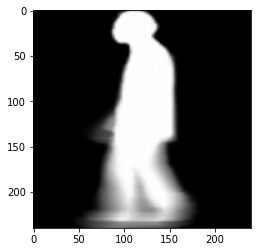

In [3]:
# load the image
img = cv2.imread('/content/00001Two-02.jpg')
# change the format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print the shape of the image
print(img.shape)
img_h, img_w, _ = img.shape
plt.imshow(img)

# Creating and Visualizing annotations

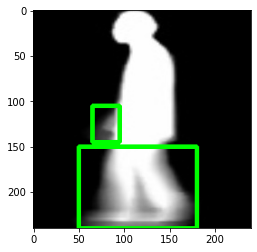

In [19]:
# creating ground truth box and labels for each ground truth
bbox_list = np.array([[50, 150, 180, 240], [65, 105, 95, 145]]) # xmin, ymax, xmax, ymin

# labels 1 for zebra, 0 for background
labels = np.array([1, 1])

# visualize ground truth box
img_ = np.copy(img)
for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3) 
plt.imshow(img_)
plt.show()    

In [20]:
bbox_list

array([[ 50, 150, 180, 240],
       [ 65, 105,  95, 145]])

# Resizing input image and annotations accordingly

3.3333333333333335 3.3333333333333335


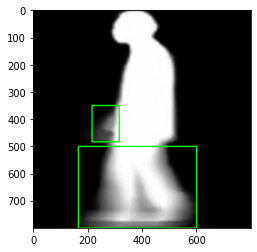

In [21]:
h = w = 800
# resize input to 800 x 800 (so that we could feed it to pre trained image classification model to extract features)
img = cv2.resize(img, dsize=(h, w), interpolation=cv2.INTER_CUBIC)
# reshape annotations accordingly
x_alter = w/img_w # compression or expansion rate in x axis (expansion in our case, because we went up in x axis, from 333 to 800)
y_alter = h/img_h # compression or expansion rate in y axis (expansion in our case, because we went up in x axis, from 500 to 800)

print(x_alter, y_alter)

# compress or expand ground truth box accordinly
bbox_list[:, 0] = bbox_list[:, 0] * x_alter
bbox_list[:, 1] = bbox_list[:, 1] * y_alter
bbox_list[:, 2] = bbox_list[:, 2] * x_alter
bbox_list[:, 3] = bbox_list[:, 3] * y_alter

img_ = np.copy(img)
for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3) 
plt.imshow(img_)
plt.show() 

# VGG network as backbone network

In [22]:
vgg = keras.applications.VGG16(
    include_top=False,
    weights="imagenet"
)
img_ = np.copy(img)[np.newaxis,:]
fe = vgg.layers
l = 0
for layer in fe:
    output = K.function([vgg.layers[0].input], [layer.output])
    print(output(img_)[0].shape, l)
    l +=1

58889256/58889256 [==============================] - 3s 0us/step
(1, 800, 800, 3) 0
(1, 800, 800, 64) 1
(1, 800, 800, 64) 2
(1, 400, 400, 64) 3
(1, 400, 400, 128) 4
(1, 400, 400, 128) 5
(1, 200, 200, 128) 6
(1, 200, 200, 256) 7
(1, 200, 200, 256) 8
(1, 200, 200, 256) 9
(1, 100, 100, 256) 10
(1, 100, 100, 512) 11
(1, 100, 100, 512) 12
(1, 100, 100, 512) 13
(1, 50, 50, 512) 14
(1, 50, 50, 512) 15
(1, 50, 50, 512) 16
(1, 50, 50, 512) 17
(1, 25, 25, 512) 18


In [23]:
backbone = Model(inputs= [vgg.layers[0].input], outputs= [vgg.layers[17].output])
backbone.predict(img_).shape

1/1 [==============================] - 7s 7s/step


(1, 50, 50, 512)

In [24]:
backbone.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0  

In [25]:
# examining the shape of feature map
feature_maps = backbone.predict(np.expand_dims(img, 0))
_, w_feature_map, h_feature_map, _ = feature_maps.shape
# number of posssible anchor positions
n_anchor_pos = w_feature_map * h_feature_map
feature_maps.shape

1/1 [==============================] - 8s 8s/step


(1, 50, 50, 512)

**Our feature map dimension size is 50\*50 (*512 depth) = 2500, so total anchor centers would be 2500***

# Creating 2500 anchor centers to place anchor boxes of different shapes and sizes

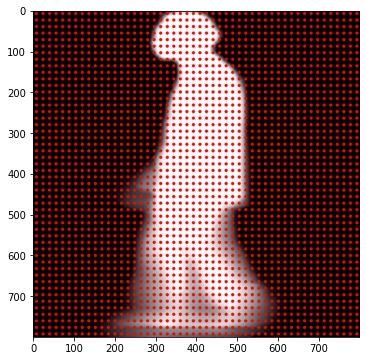

In [26]:
# generating these 2500 centers on the image, placing each of 2500 anchor location with fixed stride to match feature map shape (25*25)

# width stride on the image
x_stride = int(w / w_feature_map)
y_stride = int(h / h_feature_map)

# center (xy coordinate) of anchor location on image
x_center = np.arange(8, w, x_stride) # [  0,  32,  64,  96, 128, 160, 192,...]
y_center = np.arange(8, h, y_stride) # [  0,  32,  64,  96, 128, 160, 192,...]

# generate all the ordered pair of x and y center

# to achive this, we will use meshgrid and reshape it
center_list = np.array(np.meshgrid(x_center, y_center,  sparse=False, indexing='xy')).T.reshape(-1,2)
'''
output:
array([[  0,   0],
       [  0,  32],
       [  0,  64],
       ...,
       [768, 704],
       [768, 736],
       [768, 768]])
'''

# visualizing the anchor positions
img_ = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(n_anchor_pos):
    cv2.circle(img_, (int(center_list[i][0]), int(center_list[i][1])), radius=1, color=(255, 0, 0), thickness=5) 
plt.imshow(img_)
plt.show()

In [27]:
center_list.shape

(2500, 2)

**The red dots are the anchor centers, we will put n anchor boxes in each of this location**

# Generating anchor boxes for each anchor location

* If you notice, our ground truth box is of format "xmin, ymax, xmax, ymin" but here, we have centers, so we need format conversion from centers to min max format.
* We will use anchor boxes of different scale and aspect ratios, this image depics anchor boxes with different area/ scale and aspect ratios/ different height and width length.
<img src="https://www.researchgate.net/profile/Max-Ferguson/publication/327392506/figure/fig8/AS:666613162450944@1535944371721/Anchor-Boxes-at-a-certain-position-in-the-feature-map.png" alt="Anchor Boxes at a certain position in the feature map. | Download  Scientific Diagram" style="zoom:50%;" />

**To compute height and width given aspect ratio and area/ scale of anchor box, we will use these 
equation**
<img src="https://i.imgur.com/cCcIC3I.jpg" alt="computing height given area and aspect ratio" style="zoom:50%;" />

<img src="https://i.imgur.com/rozsNyv.jpg" alt="computing width given area and aspect ratio" style="zoom:50%;" />

In [28]:
al = []
# aspect ratio = width/ height
anchor_ratio_list = [0.5, 1, 2] # width is half of height(vertical rectangle), width = height (square), width is twice of height (horizontal rectangle)
anchor_scale_list = [8, 16, 32] # area of each anchor box

# total possible anchors 
n_anchors = n_anchor_pos * len(anchor_ratio_list) * len(anchor_scale_list)

# number of object in the image
n_object = len(bbox_list)

# there are total 2500 anchor centers each having 9 anchor boxes placed
# total anchor box in the feature map will be 2500 * 9 = 22500 each anchor box is denoted by 4 numbers.
anchor_list = np.zeros(shape= (n_anchors, 4))

count = 0
# to get height and width given ratio and scale, we will use formula given above
# for each anchor location
for center in center_list:
    center_x, center_y = center[0], center[1]
    # for each ratio
    for ratio in anchor_ratio_list:
        # for each scale
        for scale in anchor_scale_list:
            # compute height and width and scale them by constant factor
            h = pow(pow(scale, 2)/ ratio, 0.5)
            w = h * ratio

            # as h and w would be really small, we will scale them with some constant (in our case, stride width and height)
            h *= x_stride
            w *= y_stride


            # * at this point we have height and width of anchor and centers of anchor locations
            # putting anchor 9 boxes at each anchor locations
            anchor_xmin = center_x - 0.5 * w
            anchor_ymin = center_y - 0.5 * h
            anchor_xmax = center_x + 0.5 * w
            anchor_ymax = center_y + 0.5 * h
            al.append([center_x, center_y, w, h])
            # append the anchor box to anchor list
            anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
            count += 1

In [29]:
anchor_list

array([[ -37.254834  ,  -82.50966799,   53.254834  ,   98.50966799],
       [ -82.50966799, -173.01933598,   98.50966799,  189.01933598],
       [-173.01933598, -354.03867197,  189.01933598,  370.03867197],
       ...,
       [ 701.49033201,  746.745166  ,  882.50966799,  837.254834  ],
       [ 610.98066402,  701.49033201,  973.01933598,  882.50966799],
       [ 429.96132803,  610.98066402, 1154.03867197,  973.01933598]])

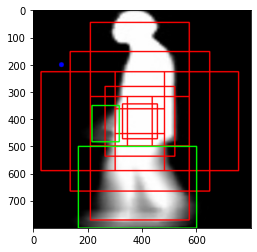

In [30]:
# visualize anchor boxs at center anchor location
img_ = np.copy(img)
# mid anchor center = 2500/2 = 1250
for i in range(11025, 11034):  # 1250 * 9 = 11025 (9 anchors corresponds to mid anchor center)
    x_min = int(anchor_list[i][0])
    y_min = int(anchor_list[i][1])
    x_max = int(anchor_list[i][2])
    y_max = int(anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)
    
cv2.circle(img_, (int(center_list[312][0]), int(center_list[312][1])), radius=1, color=(0, 0, 255), thickness=15) 

plt.imshow(img_)
plt.show()

* 9 Anchor boxes placed at middle anchor location

# Assigning lables to each anchor box
As these anchor boxes will be used as a target in our RPN network, we need to assign labels to each of these anchor boxes based on some criteria.

### IOU (intersection over union)
IOU is a way to measure overlap between two rectangular boxes. It is a popular evaluation metric in object detection, which measures the overlap between ground truth box and predicted bounding box.
<img src="https://www.researchgate.net/publication/334988907/figure/fig5/AS:788892127068163@1565097948931/Examples-of-how-Intersection-over-Union-is-calculated-Left-Poor-performance-IoU.ppm">


We will use IOU to assign labels to each of the anchor box.

Firstly:
    
    We will select all the boxes which fall inside the image.
    We will label anchor box as "1" (contains object) or positive if it has IOU/ overlap greater than equal to 0.7.
    We will label anchor box as "0" or negative if it has IOU/ overlap smaller than equal to 0.3.
    We will label anchor box as "-1" otherwise which will be discarded and won't be used as label while training.
    We will also discard all the boxes which are going beyond the image size (outside the image).

Secondly:

    We will assign each anchor box to ground truth box, which means we will assign what "ground truth" label does anchor box has maximum overlap. For instance, there might be multiple object in an image, so we assign ground truth label to anchor box denoting what ground truth box current anchor box belongs to.

Thirdly:

    We will assign each ground truth box to anchor box which has maximum IOU.

In [31]:
anchor_list

array([[ -37.254834  ,  -82.50966799,   53.254834  ,   98.50966799],
       [ -82.50966799, -173.01933598,   98.50966799,  189.01933598],
       [-173.01933598, -354.03867197,  189.01933598,  370.03867197],
       ...,
       [ 701.49033201,  746.745166  ,  882.50966799,  837.254834  ],
       [ 610.98066402,  701.49033201,  973.01933598,  882.50966799],
       [ 429.96132803,  610.98066402, 1154.03867197,  973.01933598]])

In [32]:
h = w = 800
# select anchor boxes which are inside the image
inside_anchor_idx_list = np.where(
    (anchor_list[:,0] >= 0) &
    (anchor_list[:,1] >= 0) &
    (anchor_list[:,2] <= w) &
    (anchor_list[:,3] <= h))[0]
print(inside_anchor_idx_list.shape)
inside_anchor_list = anchor_list[inside_anchor_idx_list]
n_inside_anchor = len(inside_anchor_idx_list)

(8940,)


In [33]:
anchor_list.shape, n_inside_anchor

((22500, 4), 8940)

In [34]:
def IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2
    """
    
    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    
    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0
    
    # ------computing union------
    # sum of area of both the boxes - area_overlap
    
    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])
    
    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])
    
    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2
    
    # union
    area_union = area_union_overlap - area_overlap
    
    # compute IOU
    iou = area_overlap/ area_union
    
    return iou

In [35]:
iou_list = np.zeros((n_inside_anchor, n_object))
# for each ground truth box
for gt_idx, gt_box in enumerate(bbox_list):
    # for each anchor boxes
    for anchor_idx, anchor_box in enumerate(inside_anchor_list):
        # compute IOU
        iou_list[anchor_idx][gt_idx] = IOU(gt_box, anchor_box)
        break

Overlap/ IOU: 0


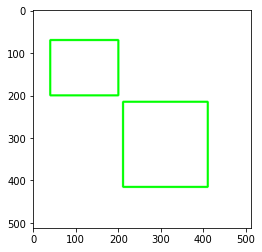

In [37]:
box1 = [40, 70, 200, 200]
box2 = [211, 215, 410, 415]
test_box = [box1, box2]
img_ = np.zeros([512,512,3],dtype=np.uint8)
img_.fill(255)
for i, bbox in enumerate(test_box):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)
    
plt.imshow(img_)
print(f"Overlap/ IOU: {IOU(box1, box2)}")

Overlap/ IOU: 0.12155539487426689


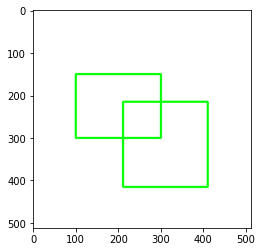

In [39]:
box1 = [100, 150, 300, 300]
box2 = [211, 215, 410, 415]
test_box = [box1, box2]
img_ = np.zeros([512,512,3],dtype=np.uint8)
img_.fill(255)
for i, bbox in enumerate(test_box):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)
    
plt.imshow(img_)
print(f"Overlap/ IOU: {IOU(box1, box2)}")

Overlap/ IOU: 0.7465570620262624


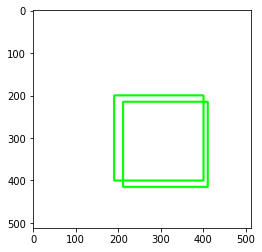

In [40]:
box1 = [190, 200, 400, 400]
box2 = [211, 215, 410, 415]
test_box = [box1, box2]
img_ = np.zeros([512,512,3],dtype=np.uint8)
img_.fill(255)
for i, bbox in enumerate(test_box):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)
    
plt.imshow(img_)
print(f"Overlap/ IOU: {IOU(box1, box2)}")

In [41]:
# computing IOU for each anchor boxes with each ground truth box
iou_list = np.zeros((n_inside_anchor, n_object))
# for each ground truth box
for gt_idx, gt_box in enumerate(bbox_list):
    # for each anchor boxes
    for anchor_idx, anchor_box in enumerate(inside_anchor_list):
        # compute IOU
        iou_list[anchor_idx][gt_idx] = IOU(gt_box, anchor_box)
# convert to dataframe

# add anchor_id
data = {"anchor_id" :inside_anchor_idx_list}

# add object column and corresponding IOU
data.update({f"object_{idx}_iou":iou_list[:, idx] for idx in range(n_object)})

# for each anchor box assign max IOU among all objects in the image
data["max_iou"] = iou_list.max(axis= 1)

# for each anchorbox assign ground truth having maximum IOU
data["best_gt"] = iou_list.argmax(axis= 1)

df_iou = pd.DataFrame(data)

In [42]:
df_iou

,anchor_id,object_0_iou,object_1_iou,max_iou,best_gt
0,1404,0.0,0.0,0.0,0
1,1413,0.0,0.0,0.0,0
2,1422,0.0,0.0,0.0,0
3,1431,0.0,0.0,0.0,0
4,1440,0.0,0.0,0.0,0
...,...,...,...,...,...
8935,21051,0.0,0.0,0.0,0
8936,21060,0.0,0.0,0.0,0
8937,21069,0.0,0.0,0.0,0
8938,21078,0.0,0.0,0.0,0


In [43]:
# getting anchor boxes having maximum IOU for each ground truth boxes
best_ious = df_iou.drop(["anchor_id", "max_iou", "best_gt"],axis= 1).max().values
print(f"Top IOUs for each object in the image: {best_ious}")

# getting anchor box idx having maximum overlap with ground truth boxes * ignoring anchor id column
best_anchors = df_iou.drop(["anchor_id", "max_iou", "best_gt"],axis= 1).values.argmax(axis= 0)
print(f"Top anchor boxes index: {best_anchors}")

# get all the anchor boxes having same IOU score
top_anchors = np.where(iou_list == best_ious)[0]
print(f"Anchor boxes with same IOU score: {top_anchors}")

Top IOUs for each object in the image: [0.50334869 0.70754717]
Top anchor boxes index: [3887 2334]
Anchor boxes with same IOU score: [2334 2580 3887 3893 3898 3903 3908 3912 3916 4159 4166 4172 4177 4182
 4186 4190 4433 4440 4446 4451 4456 4460 4464 4707 4714 4720 4725 4730
 4734 4738]


* For object 1, best anchor box has 65.6% overlap with ground truth box.
* For object 2, best anchor box has 67.7% overlap with ground truth box.
* Anchor box 1863 (for object 1) and 4384 (for object 2) has the best overlap with ground truth box
* Lastly, list of anchor boxes having same top IOU score

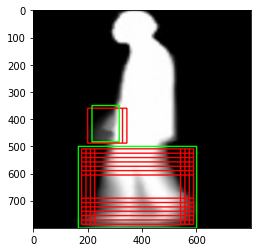

In [44]:
# visualizing top anchor boxes
img_ = np.copy(img)
for i in top_anchors:  # 5625// 2
    x_min = int(inside_anchor_list[i][0])
    y_min = int(inside_anchor_list[i][1])
    x_max = int(inside_anchor_list[i][2])
    y_max = int(inside_anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()

**Red-> best anchor box**

**Green -> ground truth box**

In [45]:
# labeling each anchor box based on IOU threshold

# create dummy column
label_column = np.zeros(df_iou.shape[0], dtype= np.int)
label_column.fill(-1)

# label top anchor boxes as 1 # contains object
label_column[top_anchors] = 1

# label anchor boxes having IOU > 0.7 with ground truth boxes as 1 # contains object
label_column[np.where(df_iou.max_iou.values >= 0.7)[0]] = 1

# label anchor boxes having IOU < 0.3 with ground truth boxes as 0 # background
label_column[np.where(df_iou.max_iou.values < 0.3)[0]] = 0

# add column to the iou dataframe
df_iou["label"] = label_column

<ipython-input-45-8c0c4b29e415>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_column = np.zeros(df_iou.shape[0], dtype= np.int)


# Balancing anchor labels
As most of the classes will be of background (class 0), our model would be biased towards majority class, so we take 1:1 ratio (number of background examples will be equal to foreground) to train our RPN model 256 samples (overall, postive class + background class).

If we don't have enough foreground class, we will sample background class (class 0) to fill in the gaps.

eg: we have total of 256 samples, we take 128 of background class and 128 of foreground class, if we have less foreground class than 128 (lets say 100 postive class instances), we will sample more negative points (28 in our case) to pad.

In [46]:
def sample_anchors_pre(df, n_samples= 256, neg_ratio= 0.5):
    """
    Sample total of n samples across both the class (background and foreground),
    If one of the class have less samples than n/2, we will sample from majority class to make up for short.
    """
    n_foreground = int((1-neg_ratio) * n_samples)
    n_backgroud = int(neg_ratio * n_samples)
    foreground_index_list = df[df.label == 1].index.values
    background_index_list = df[df.label == 0].index.values

    # check if we have excessive positive samples
    if len(foreground_index_list) > n_foreground:
        # mark excessive samples as -1 (ignore)
        ignore_index = foreground_index_list[n_backgroud:]
        df.loc[ignore_index, "label"] = -1

    # sample background examples if we don't have enough positive examples to match the anchor batch size
    if len(foreground_index_list) < n_foreground:
        diff = n_foreground - len(foreground_index_list)
        # add remaining to background examples
        n_backgroud += diff

    # check if we have excessive background samples
    if len(background_index_list) > n_backgroud:
        # mark excessive samples as -1 (ignore)
        ignore_index = background_index_list[n_backgroud:]
        df.loc[ignore_index, "label"] = -1

In [47]:
sample_anchors_pre(df_iou)

# Computing anchor offsets with cooresponding ground truth box
We train RPN to predict "the difference between anchor box and ground truth box" (or the offset of anchor box to ground truth box) so that we could adjust the anchor box to match the ground truth box.

As we already have anchor boxes, we just need to adjust them to the best/ nearest ground truth boxes. These adjustment is give by:

t_{x} = (x - x_{a})/w_{a} # predict the horizontal difference (we will add this to the achor box x coordinate)
 
t_{y} = (y - y_{a})/h_{a} # predict the vertical difference (we will add this to the achor box y coordinate)
 
t_{w} = log(w/ w_a) # predict log of ratio between ground truth and achor width(we will multiply this to the achor box width)
 
t_{h} = log(h/ h_a) # predict log of ratio between ground truth and achor height(we will multiply this to the achor box height)

x, y , w, h are the groud truth box center co-ordinates, width and height. x_a, y_a, h_a and w_a and anchor boxes center cooridinates, width and height.

We will reverse the process to get the actual predicted bounding box.

**Before proceeding, we need to convert anchor and ground truth coordinate from xmin, ymin, xmax, ymax to x_center, y_center, height and width to make above adjustment possible**

In [48]:
# for each valid anchor box coordinate, convert coordinate format
inside_anchor_width, inside_anchor_height, inside_anchor_center_x, inside_anchor_center_y =  to_center_format(
    inside_anchor_list[:, 0], 
    inside_anchor_list[:, 1],
    inside_anchor_list[:, 2],
    inside_anchor_list[:, 3])


# for each ground truth box corresponds to each anchor box coordinate, convert coordinate format
gt_coordinates = []
for idx in df_iou.best_gt:
    gt_coordinates.append(bbox_list[idx])
gt_coordinates = np.array(gt_coordinates)

base_width, base_height, base_center_x, base_center_y =  to_center_format(
    gt_coordinates[:, 0], 
    gt_coordinates[:, 1],
    gt_coordinates[:, 2],
    gt_coordinates[:, 3])

In [49]:
# the code below prevents from "exp overflow"
eps = np.finfo(inside_anchor_width.dtype).eps
inside_anchor_height = np.maximum(inside_anchor_height, eps)
inside_anchor_width = np.maximum(inside_anchor_width, eps)

# computing offset given by above expression
dx = (base_center_x - inside_anchor_center_x)/ inside_anchor_width  # difference in centers of ground truth and anchor box across x axis
dy = (base_center_y - inside_anchor_center_y)/  inside_anchor_height  # difference in centers of ground truth and anchor box across y axis
dw = np.log(base_width/ inside_anchor_width) # log on ratio between ground truth width and anchor box width
dh = np.log(base_height/ inside_anchor_height) # log on ratio between ground truth height and anchor box height

In [50]:
# adding offsets to the df
df_iou["dx"] = dx
df_iou["dy"] = dy
df_iou["dw"] = dw
df_iou["dh"] = dh

# Final Labels And Offset List

In [51]:
# labels for all possible anchors
label_list = np.empty(n_anchors, dtype = np.float32)
label_list.fill(-1)
label_list[df_iou.anchor_id.values] = df_iou.label.values
label_list = np.expand_dims(label_list, 0)
label_list = np.expand_dims(label_list, -1)

In [52]:
df_iou

,anchor_id,object_0_iou,object_1_iou,max_iou,best_gt,label,dx,dy,dw,dh
0,1404,0.0,0.0,0.0,0,0,3.612874,3.016252,1.567588,0.505179
1,1413,0.0,0.0,0.0,0,0,3.612874,2.927864,1.567588,0.505179
2,1422,0.0,0.0,0.0,0,0,3.612874,2.839476,1.567588,0.505179
3,1431,0.0,0.0,0.0,0,0,3.612874,2.751087,1.567588,0.505179
4,1440,0.0,0.0,0.0,0,0,3.612874,2.662699,1.567588,0.505179
...,...,...,...,...,...,...,...,...,...,...
8935,21051,0.0,0.0,0.0,0,-1,-3.988524,0.099437,1.567588,0.505179
8936,21060,0.0,0.0,0.0,0,-1,-3.988524,0.011049,1.567588,0.505179
8937,21069,0.0,0.0,0.0,0,-1,-3.988524,-0.077340,1.567588,0.505179
8938,21078,0.0,0.0,0.0,0,-1,-3.988524,-0.165728,1.567588,0.505179


In [53]:
# Offset for all possible anchors
offset_list = np.empty(shape= anchor_list.shape, dtype= np.float32)
offset_list.fill(0)
offset_list[df_iou.anchor_id.values] = df_iou[["dx", "dy", "dw", "dh"]].values
offset_list = np.expand_dims(offset_list, 0)

In [54]:
# shape of both the array
offset_list.shape, label_list.shape

((1, 22500, 4), (1, 22500, 1))

In [55]:
# combine deltas and objectiveness score in one array
offset_list_label_list = np.column_stack((offset_list[0], label_list[0]))[np.newaxis,:]

In [56]:
input_shape = (w_feature_map, h_feature_map, 512) # 50x50X512
k = 9
input_ = Input(shape= input_shape)
conv1 = Conv2D(512,
               kernel_size= 3,
               padding= "same",
               kernel_initializer=initializers.RandomNormal(stddev=0.01),
               bias_initializer=initializers.Zeros())(input_) # (kw * iw + 2*padding_w / s_w) + 1

# delta regression
regressor = Conv2D(4*k,
                   kernel_size= 1,
                   activation= "linear",
                   name= "delta_regression",
                  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                  bias_initializer=initializers.Zeros())(conv1) # (-1, 36)

# objectiveness score
classifier = Conv2D(k*1,
                    kernel_size= 1,
                    activation= "sigmoid",
                    name="objectivess_score",
                    kernel_initializer=initializers.RandomNormal(stddev=0.01),
                    bias_initializer=initializers.Zeros())(conv1)

RPN = Model(inputs= [input_], outputs= [regressor, classifier])

In [57]:
RPN.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 512  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 512)  2359808     ['input_2[0][0]']                
                                                                                                  
 delta_regression (Conv2D)      (None, 50, 50, 36)   18468       ['conv2d[0][0]']                 
                                                                                                  
 objectivess_score (Conv2D)     (None, 50, 50, 9)    4617        ['conv2d[0][0]']          

# Custom loss function

In [58]:
def smooth_l1_loss(y_true, y_pred):
    """
    Calculates Smooth L1 loss
    """

    # Take absolute difference
    x = K.abs(y_true - y_pred)

    # Find indices of values less than 1
    mask = K.cast(K.less(x, 1.0), "float32")
    # Loss calculation for smooth l1
    loss = (mask * (0.5 * x ** 2)) + (1 - mask) * (x - 0.5)
    return loss


def custom_l1_loss(y_true, y_pred):
    """
    Regress anchor offsets(deltas) * only consider foreground boxes
    """
    offset_list= y_true[:,:,:-1]
    label_list = y_true[:,:,-1]
    
    # reshape output by the model
    y_pred = tf.reshape(y_pred, shape= (-1, n_anchors, 4))
    
    positive_idxs = tf.where(K.equal(label_list, 1)) # select only foreground boxes
    
    # Select positive predicted bbox shifts
    bbox = tf.gather_nd(y_pred, positive_idxs)
    
    target_bbox = tf.gather_nd(offset_list, positive_idxs)
    loss = smooth_l1_loss(target_bbox, bbox)

    return K.mean(loss)

def custom_binary_loss(y_true, y_pred_objectiveness):
    '''
    Select both foreground and background class and compute cross entropy
    '''
    
    y_pred = tf.reshape(y_pred_objectiveness, shape= (-1, n_anchors))
    y_true = tf.squeeze(y_true, -1)
    
    # Find indices of positive and negative anchors, not neutral
    indices = tf.where(K.not_equal(y_true, -1)) # ignore -1 labels

    # Pick rows that contribute to the loss and filter out the rest.
    rpn_match_logits = tf.gather_nd(y_pred, indices)
    anchor_class = tf.gather_nd(y_true, indices)
    
    
    # Cross entropy loss
    loss = K.binary_crossentropy(target=anchor_class,
                                output=rpn_match_logits
                                )
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    
    return loss

RPN.compile(loss = [custom_l1_loss, custom_binary_loss], optimizer= "adam")

In [59]:
label_list.shape, offset_list_label_list.shape, feature_maps.shape

((1, 22500, 1), (1, 22500, 5), (1, 50, 50, 512))

In [60]:
RPN.fit(feature_maps,[offset_list_label_list, label_list], epochs= 100)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7311 - delta_regression_loss: 0.0462 - objectivess_score_loss: 0.6850
Epoch 2/100
1/1 [==============================] - 1s 501ms/step - loss: 0.5574 - delta_regression_loss: 0.3810 - objectivess_score_loss: 0.1764
Epoch 3/100
1/1 [==============================] - 0s 477ms/step - loss: 0.2179 - delta_regression_loss: 0.1205 - objectivess_score_loss: 0.0974
Epoch 4/100
1/1 [==============================] - 0s 499ms/step - loss: 0.2384 - delta_regression_loss: 0.1795 - objectivess_score_loss: 0.0589
Epoch 5/100
1/1 [==============================] - 0s 480ms/step - loss: 0.1734 - delta_regression_loss: 0.1356 - objectivess_score_loss: 0.0378
Epoch 6/100
1/1 [==============================] - 0s 489ms/step - loss: 0.1061 - delta_regression_loss: 0.0800 - objectivess_score_loss: 0.0261
Epoch 7/100
1/1 [==============================] - 0s 482ms/step - loss: 0.0739 - delta_regression_loss: 0.0539 - objectivess_score_l

In [61]:
# get the offset and objectiveness score
anchor_deltas, objectiveness_score = RPN.predict(feature_maps)


# shape both predictions
anchor_deltas = anchor_deltas.reshape(-1, n_anchors, 4) # 50*50*9, 4
objectiveness_score = objectiveness_score.reshape(-1, n_anchors) # 50*50*9, 1

# parse anchor deltas
dx = anchor_deltas[:, :, 0]
dy = anchor_deltas[:, :, 1]
dw = anchor_deltas[:, :, 2]
dh = anchor_deltas[:, :, 3]

print(anchor_deltas.shape, objectiveness_score.shape)

1/1 [==============================] - 0s 268ms/step
(1, 22500, 4) (1, 22500)


# Clipping, Filtering And Non-max Suppression(NMS)
Now we have anchor deltas and objectiveness score for each anchor boxes, we will adjust our anchor boxes (based on the deltas), further process them and filter boxes based on the following:
* Clip the proposals boxes to the image.
* Remove the proposals whos height or width is less than some threshold value.
* Sort all proposals based on the objectiveness score.

In [62]:
anchor_list = anchor_list.squeeze()
anchor_list = np.expand_dims(anchor_list, 0)

In [63]:
# for each anchor box, convert coordinate format (min_x, min_y, max_x, max_y to height, width, center_x)
anchor_width, anchor_height, anchor_center_x, anchor_center_y =  to_center_format(
    anchor_list[0][:, 0], 
    anchor_list[0][:, 1],
    anchor_list[0][:, 2],
    anchor_list[0][:, 3])

# get the region proposals (adjust the anchor boxes to the offset predicted by our model)
roi_width, roi_height, roi_center_x, roi_center_y = adjust_deltas(anchor_width,
                                                      anchor_height,
                                                      anchor_center_x,
                                                      anchor_center_y,
                                                      dx,
                                                      dy,
                                                      dw,
                                                      dh)

In [64]:
# ROI format conversion (width, height,center x, centery ===> min x, min y, max x, max y)
roi_min_x, roi_min_y, roi_max_x, roi_max_y = to_VOC_format(roi_width, roi_height, roi_center_x, roi_center_y)
roi = np.vstack((roi_min_x, roi_min_y, roi_max_x, roi_max_y)).T

In [65]:
# clipping the predicted boxes to the image
roi = np.clip(roi, 0, 800)

In [66]:
# remove predicted boxes with either height or width < threshold.
min_size = 16
width = roi[:, 2] - roi[:, 0] # xmax - xmin
height = roi[:, 3] - roi[:, 1] # ymin - ymax
keep = np.where((width > min_size) & (height> min_size))[0]
roi = roi[keep]
score = objectiveness_score[:,keep]

In [67]:
# Sort all (proposal, score) pairs by score from highest to lowest.
sorted_idx = score.flatten().argsort()[::-1]
score_sorted = score[:, sorted_idx]
roi_sorted = roi[sorted_idx]

In [68]:
sorted_idx.shape, score_sorted.shape, roi_sorted.shape

((19289,), (1, 19289), (19289, 4))

* Select top N proposals (pre_NMS_topN) from the sorted roi and scores
* apply NMS to eliminate highly overlapping anchor box (ROI proposals) and select 2000 filtered proposals

In [69]:
# select top N proposals (top 12000)
pre_NMS_topN = 12000
score_sorted = score_sorted[:, :pre_NMS_topN]
roi_sorted = roi_sorted[:pre_NMS_topN]

In [70]:
# apply non-max supression on 12000 roi
roi_idx = np.array(range(pre_NMS_topN))

# total number of ROIs to select after NMS
n_train_post_nms = 2000


x1 = roi_sorted[:, 0]
y1 = roi_sorted[:, 1]
x2 = roi_sorted[:, 2]
y2 = roi_sorted[:, 3]

# area of all roi
# + 1 to prevent division by zero
width_list = (x2 - x1) + 1 
height_list = (y2 - y1) + 1
area_list =  width_list * height_list

# rois to keep as region proposals
keep = []

while roi_idx.size > 0:
    # take the first roi index
    current_id = roi_idx[0]
    
    # add the current rio to keep list
    keep.append(current_id)
    
    # maximum of x1 of current and all other x1 roi
    xx1 = np.maximum(x1[current_id], x1[roi_idx[1:]])
    
    # maximum of y1 of current and all other y1 roi
    yy1 = np.maximum(y1[current_id], y1[roi_idx[1:]])
    
    # maximum of x2 of current and all other x2 roi
    xx2 = np.minimum(x2[current_id], x2[roi_idx[1:]])
    
    # maximum of y2 of current and all other y2 roi
    yy2 = np.minimum(y2[current_id], y2[roi_idx[1:]])
    
    # width of all the intersection area
    w = np.maximum(0. ,xx2 - xx1 +1)
    
    # height of all the intersection boxes
    h = np.maximum(0., yy2 - yy1 +1)
    
    # area of all the intersection boxes
    inter = w * h
    
    # IOU current ROI and rest of the ROIs
    iou = inter/ (area_list[current_id] + area_list[roi_idx[1:]] - inter)
    # select boxes whose overlap is less than the threshold
    keep_idx = np.where(iou <= 0.7)[0]
    
    # update the ROI index list(* note +1 to the indices list)
    roi_idx = roi_idx[keep_idx + 1]

In [71]:
# select only top 2000 proposals
keep = keep[: n_train_post_nms]
roi_sorted = roi_sorted[keep]
score_sorted = score_sorted[:, keep]

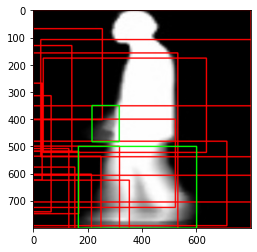

In [72]:
# visualizing top 20 anchor boxes
img_ = np.copy(img)
for i in range(0, 20):  # 5625// 2
    x_min = int(roi_sorted[i][0])
    y_min = int(roi_sorted[i][1])
    x_max = int(roi_sorted[i][2])
    y_max = int(roi_sorted[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()

# Final Post Processing ( assigning ground truth boxes and lables to the top 2000 region proposals (adjusted anchor boxes)
After getting top 2000 anchor boxes, we will assign each of the anchor box to the ground truth box based on the IOU ( exactly same process as we have performed earlier).

After assignment of ground truth boxes to the region proposals, we will further eliminate the anchor boxes based on the following rule.
* Assign label "1" (as foreground) to the bounding boxes whose overlap with any ground truth box is greater than 50%
* Assign label "0" (as background) to the bounding boxes whose overlap with any ground truth box is smaller than 50% but greater than equal to 10%.

In [73]:
# find IOU of all region proposals with all ground truth boxes
iou_sorted = np.zeros((n_train_post_nms, len(labels)))

# for each proposal
for i, bbox in enumerate(roi_sorted):
    
    # for each ground truth box
    for j, gt_box in enumerate(bbox_list):
        iou_sorted[i][j] = IOU(bbox, gt_box)

# get the max iou for each proposal
max_iou_sorted = np.max(iou_sorted, axis= 1)

# assign the ground truth box to each proposal
gt_assign = np.argmax(iou_sorted, axis= 1)

# assign class labels to each proposal
gt_roi_label = labels[gt_assign] # {"dog":1, "cat":2, and so on}, this will be used by RPN classification head

In [74]:
# threshold for foreground and background labels
pos_threshold = 0.5
neg_threshold_hi = 0.5
neg_threshold_lo = 0.1

# select proposals whose IOU is atleast 50%
keep_pos_idx_list = np.where(max_iou_sorted >= pos_threshold)[0]

# select proposals whose IOU is less than 50% but greater than or equal to lower limit 10%
keep_neg_idx_list = np.where((max_iou_sorted < neg_threshold_hi) & (max_iou_sorted >=neg_threshold_lo))[0]

In [75]:
# select 128 proposals of both classes (foreground and background)
n_samples = 128
neg_ratio = 0.75
# number of foreground and background class
n_foreground = int((1-neg_ratio) * n_samples)
n_backgroud = int(neg_ratio * n_samples)

# index of foreground and background ROIs
foreground_index_list = keep_pos_idx_list
background_index_list = keep_neg_idx_list

# check if we have excessive foreground samples
if len(foreground_index_list) > n_foreground:
    # randomly sample 32 foreground proposals
    select_pos_index_list = np.random.choice(foreground_index_list, n_foreground)
else:
    select_pos_index_list = foreground_index_list

# sample background examples if we don't have enough positive examples to match the anchor batch size
if len(foreground_index_list) < n_foreground:
    diff = n_foreground - len(foreground_index_list)
    # add remaining value to background examples
    n_backgroud += diff

# check if we have excessive background samples
if len(background_index_list) > n_backgroud:
    # randomly sample remaining proposals as negative
    select_neg_index_list = np.random.choice(background_index_list, n_backgroud)
else:
    select_neg_index_list = background_index_list

# combine both the index list, foreground and background
keep = np.hstack([select_pos_index_list, select_neg_index_list])

In [76]:
# select corresponding proposals and labels
sample_roi = roi_sorted[keep]
gt_roi_labels = gt_roi_label[keep]
# mark the background classes
gt_roi_labels[select_pos_index_list.shape[0]:] = 0

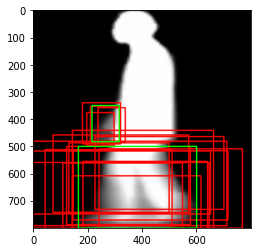

In [77]:
# visualizing foreground proposals
img_ = np.copy(img)

for i in range(18):  # 5625// 2
    # visualizing foreground proposals
    x_min = int(sample_roi[i][0])
    y_min = int(sample_roi[i][1])
    x_max = int(sample_roi[i][2])
    y_max = int(sample_roi[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()

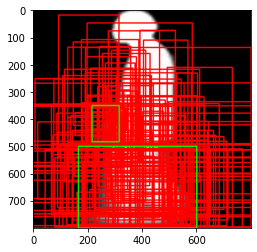

In [78]:
# visualizing background proposals
img_ = np.copy(img)

for i in range(128):  # 5625// 2
    x_min = int(sample_roi[i][0])
    y_min = int(sample_roi[i][1])
    x_max = int(sample_roi[i][2])
    y_max = int(sample_roi[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv2.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()

# References, Sources and Citations
https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439